In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science',  'bright'])


In [98]:
def freq_bar(real_y, fake_y, title, real_y_std=None, fake_y_std=None):
    skin_list = ['Lighter', 'Darker']

    fig, ax = plt.subplots()
    x = np.arange(len(skin_list))
    width = 0.35

    p1 = ax.bar(x - width/2, real_y, width, label='Real', 
        ecolor='black', )
    p2 = ax.bar(x + width/2, fake_y, width, label='Fake', 
        ecolor='black', )
    ax.bar_label(p1, fmt='%.3f')
    ax.bar_label(p2, fmt='%.3f')

    ax.set_title(title)

    ax.set_xticks(x)
    ax.set_xticklabels(skin_list)
    
    ax.set_ylabel('Accuracy')
    ax.set_ylim((0.4, 0.8))

    ax.legend()
    return fig

In [11]:
training = [
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40000.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40007.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40001.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40009.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40019.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3996.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3991.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3959.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3939.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3933.png'
]

labels = [
    0, 0, 1, 1, 0, 0, 1, 0, 1, 1
]

In [12]:
skin_fn = lambda x: "Lighter" if x == 1 else "Darker"
labels = list(map(skin_fn, labels))

In [13]:
hints = [f"This face has a {skin} skin." for skin in labels]

In [16]:
skin_training = pd.read_csv('fairness/training.tsv', sep='\t').iloc[0:0]

In [17]:
skin_training['INPUT:image'] = training
skin_training['GOLDEN:result'] = labels
skin_training['HINT:text'] = hints

In [20]:
skin_training.to_csv('fairness/training.tsv', sep='\t', index=None)

In [24]:
cols = ['INPUT:image']
org = pd.read_csv('org_label.csv')[cols]
fake = pd.read_csv('fake_label.csv')[cols]

In [34]:
sampled = pd.concat((org[:100], fake[:100]))

In [36]:
sampled.to_csv('fairness/sampled.tsv', sep='\t', index=None)

In [37]:
rest = pd.concat((org[100:], fake[100:]))

In [40]:
rest.to_csv('fairness/rest.tsv', sep='\t', index=None)

## Analysis

In [101]:
link2id = lambda x: x.split('/')[-1].split('"')[0]

In [102]:
res = pd.read_csv('fairness/results/assignments_from_pool_33873013__13-06-2022.tsv', sep='\t')

In [103]:
res = res[::2][['INPUT:image', 'OUTPUT:result']]

In [104]:
res['result'] = res['OUTPUT:result'].apply(lambda x: 1 if x == 'Darker' else 0)

In [105]:
res = res.groupby('INPUT:image').sum()

In [106]:
from copy import deepcopy
final_res = deepcopy(res)
final_res['skin'] = final_res['result'].apply(lambda x: 1 if x >= 2 else 0)
final_res = final_res.drop(['result'], axis=1)

In [107]:
final_res = final_res.reset_index()

In [108]:
final_res['INPUT:image'] = final_res['INPUT:image'].apply(link2id)

In [109]:
sum(final_res['skin']) / len(final_res)

0.089

In [110]:
org_imgs_acc = pd.read_csv('org_imgs_worker_acc.csv')
fake_imgs_acc = pd.read_csv('fake_imgs_worker_acc.csv')

In [111]:
img_acc = pd.concat((org_imgs_acc, fake_imgs_acc))

In [112]:
skin_acc = final_res.merge(img_acc, on='INPUT:image')

In [113]:
skin_acc

,INPUT:image,skin,n_workers,acc
0,img_1.png,1,3.0,0.666667
1,img_101.png,0,2.0,0.000000
2,img_103.png,0,2.0,1.000000
3,img_105.png,0,4.0,0.750000
4,img_107.png,0,5.0,0.800000
...,...,...,...,...
995,40996.png,0,4.0,0.750000
996,40997.png,0,4.0,1.000000
997,40998.png,0,4.0,1.000000
998,40999.png,0,4.0,0.750000


In [120]:
skin_acc[500:].groupby('skin').mean()

,n_workers,acc
skin,,
0,3.663636,0.821591
1,3.566667,0.843611


In [119]:
skin_acc[:500].groupby('skin').mean()

,n_workers,acc
skin,,
0,3.511677,0.672435
1,3.827586,0.773563


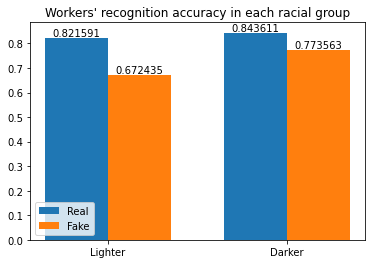

In [128]:
fig = freq_bar(
    skin_acc[500:].groupby('skin').mean()['acc'],
    skin_acc[:500].groupby('skin').mean()['acc'],
    "Workers' recognition accuracy in each racial group"
)

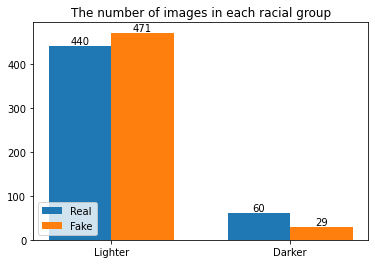

In [129]:
fig = freq_bar(
    skin_acc[500:]['skin'].value_counts().sort_index(),
    skin_acc[:500]['skin'].value_counts().sort_index(),
    "The number of images in each racial group"
)

## Create Balenced Skin Pool

`0` indicates lighter skin, and `1` indicates darker skin.

In [3]:
true_imgs = pd.read_csv('true_img.csv', header=None, names=['INPUT:image', 'skin'])
fake_imgs = pd.read_csv('fake_skin.csv').dropna().astype({'skin': int})
fake_imgs['INPUT:image'] = fake_imgs['INPUT:image'].apply(
    lambda x: f"https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/{x}")

In [4]:
true_imgs_lighter = true_imgs[true_imgs['skin'] == 0]
true_imgs_darker = true_imgs[true_imgs['skin'] == 1]

In [5]:
fake_imgs_lighter = fake_imgs[fake_imgs['skin'] == 0]
fake_imgs_darker = fake_imgs[fake_imgs['skin'] == 1]

In [6]:
balanced_set_control = pd.concat((
    true_imgs_lighter[:50], true_imgs_darker[:50],
    fake_imgs_lighter[:50], fake_imgs_darker[:50],
))

balanced_set_general = pd.concat((
    true_imgs_lighter[50:100], true_imgs_darker[50:100],
    fake_imgs_lighter[50:100], fake_imgs_darker[50:100],
))

In [105]:
balanced_set = pd.concat((
    true_imgs_lighter[:100], true_imgs_darker[:100],
    fake_imgs_lighter[:100], fake_imgs_darker[:100],
))

In [29]:
control_task = pd.read_csv("tasks_for_pool_33923754__15-06-2022.tsv", sep='\t')[:0]

In [30]:
control_task['INPUT:image'] = balanced_set['INPUT:image']
control_task['GOLDEN:result'] = [0] * 200 + [1] * 200 

In [31]:
control_task[['INPUT:image', 'GOLDEN:result']].to_csv('control_tasks.tsv', index=None, sep='\t')

### Worker Skin Labels

In [17]:
balanced_set

,INPUT:image,skin
0,https://raw.githubusercontent.com/BirkhoffG/cr...,0
1,https://raw.githubusercontent.com/BirkhoffG/cr...,0
3,https://raw.githubusercontent.com/BirkhoffG/cr...,0
4,https://raw.githubusercontent.com/BirkhoffG/cr...,0
5,https://raw.githubusercontent.com/BirkhoffG/cr...,0
...,...,...
1049,https://raw.githubusercontent.com/BirkhoffG/cr...,1
1059,https://raw.githubusercontent.com/BirkhoffG/cr...,1
1079,https://raw.githubusercontent.com/BirkhoffG/cr...,1
1086,https://raw.githubusercontent.com/BirkhoffG/cr...,1


In [102]:
worker_skin_labels = pd.read_csv(
    'fairness/darker_lighter_worker/assignments_from_pool_33958247__18-06-2022.tsv', sep='\t')
worker_skin_labels = worker_skin_labels.dropna(axis=0, how='all')
worker_skin_labels['skin'] = worker_skin_labels['OUTPUT:result'].apply(
    lambda x: 1 if x == 'Darker' else 0
)
worker_skin_labels = worker_skin_labels[['INPUT:image', 'skin']]
worker_skin_labels_grouped = worker_skin_labels.groupby('INPUT:image').mean()
worker_skin_labels_grouped = worker_skin_labels_grouped.reset_index()
worker_skin_labels_grouped['skin'] = worker_skin_labels_grouped['skin'].apply(
    lambda x: 1 if x >= 0.5 else 0
)
worker_skin_labels_grouped

,INPUT:image,skin
0,https://raw.githubusercontent.com/BirkhoffG/cr...,0
1,https://raw.githubusercontent.com/BirkhoffG/cr...,0
2,https://raw.githubusercontent.com/BirkhoffG/cr...,1
3,https://raw.githubusercontent.com/BirkhoffG/cr...,0
4,https://raw.githubusercontent.com/BirkhoffG/cr...,0
...,...,...
395,https://raw.githubusercontent.com/BirkhoffG/cr...,0
396,https://raw.githubusercontent.com/BirkhoffG/cr...,1
397,https://raw.githubusercontent.com/BirkhoffG/cr...,1
398,https://raw.githubusercontent.com/BirkhoffG/cr...,0


In [106]:
author_worker_labels = balanced_set.merge(
    worker_skin_labels_grouped, on='INPUT:image', suffixes=('_author', '_worker'))
disagreements = author_worker_labels['skin_author'] != author_worker_labels['skin_worker']
author_worker_labels[disagreements].to_csv('disagreements.csv', index=None, sep='\t')

In [112]:
author_worker_labels['INPUT:image'][200]

'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_2.png'

/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


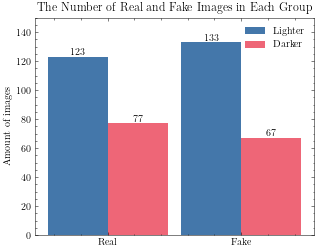

In [150]:
def freq_bar(light_y, dark_y, title):
    skin_list = ['Real', 'Fake']

    fig, ax = plt.subplots(figsize=(5,4))
    x = np.arange(len(skin_list))
    width = 0.45

    p1 = ax.bar(x - width/2, light_y, width, label='Lighter', 
        ecolor='black', )
    p2 = ax.bar(x + width/2, dark_y, width, label='Darker', 
        ecolor='black', )
    ax.bar_label(p1, )
    ax.bar_label(p2, )

    ax.set_title(title)

    ax.set_xticks(x)
    ax.set_xticklabels(skin_list)
    
    ax.set_ylabel('Amount of images')
    ax.set_ylim((0, 150))

    ax.legend()
    # fig.legend('right')
    return fig

rl = author_worker_labels[:200][author_worker_labels['skin_worker'] == 0]
rd = author_worker_labels[:200][author_worker_labels['skin_worker'] == 1]
fl = author_worker_labels[200:400][author_worker_labels['skin_worker'] == 0]
fd = author_worker_labels[200:400][author_worker_labels['skin_worker'] == 1]

freq_bar(
    [len(rl), len(fl)],
    [len(rd), len(fd)],
    "The Number of Real and Fake Images in Each Group"
).savefig('real_fake_images_amount.pdf')

### Analysis

In [176]:
def freq_bar(light_y, dark_y, title, ):
    skin_list = ['Base Failure Rate', 'Pass Rate']

    fig, ax = plt.subplots(figsize=(5,4))
    x = np.arange(len(skin_list))
    width = 0.45

    p1 = ax.bar(x - width/2, light_y, width, label='Lighter', 
        ecolor='black', )
    p2 = ax.bar(x + width/2, dark_y, width, label='Darker', 
        ecolor='black', )
    ax.bar_label(p1, fmt='%.3f')
    ax.bar_label(p2, fmt='%.3f')

    ax.set_title(title)

    ax.set_xticks(x)
    ax.set_xticklabels(skin_list)
    
    ax.set_ylabel('Rate')
    # ax.set_ylim((0.4, 0.8))

    ax.legend()
    return fig

In [186]:
from scipy.stats import ttest_ind

def normalize_confidence(x):
    # {0: 'Very confident', 1: 'Somewhat confident', 2: 'Not confident'} ==> {0: 'Not confident', 0.5: 'Somewhat confident', 1: 'Very confident'}
    return dict(zip(range(3), [1., 0.5, 0.]))[x]


def get_real_fake_acc(result_path, balanced_set, metrics='acc'):
    if metrics not in ['acc', 'OUTPUT:confidence']:
        raise ValueError("metrics must be either 'acc' or 'OUTPUT:confidence'")
    
    worker_acc = pd.read_csv(result_path, sep='\t').dropna(axis=0, how='all')
    worker_acc['n_tasks'] = np.ones(len(worker_acc))
    worker_acc['INPUT:image'] = worker_acc['INPUT:image'].apply(lambda x: x.replace('"', ''))
    worker_acc['n_tasks'] = np.ones(len(worker_acc))
    worker_acc['OUTPUT:confidence'] = worker_acc['OUTPUT:confidence'].apply(normalize_confidence)
    worker_acc = worker_acc[:2000]
    # worker's acc for each image
    imgs_acc = worker_acc[['INPUT:image', 'OUTPUT:result', 'GOLDEN:result', 'n_tasks', 'OUTPUT:confidence']].groupby('INPUT:image').sum().reset_index()
    imgs_acc = imgs_acc.merge(balanced_set, on='INPUT:image')
    imgs_acc['OUTPUT:confidence'] = imgs_acc['OUTPUT:confidence'] / imgs_acc['n_tasks']
    imgs_acc_real = imgs_acc[imgs_acc['GOLDEN:result'] == 0.]
    imgs_acc_fake = imgs_acc[imgs_acc['GOLDEN:result'] > 0.]

    # real and fake accuracy
    imgs_acc_fake['acc'] = imgs_acc_fake['OUTPUT:result'] / imgs_acc_fake['GOLDEN:result']
    imgs_acc_real['acc'] = (imgs_acc_real['n_tasks'] - imgs_acc_real['OUTPUT:result']) / (imgs_acc_real['n_tasks'] - imgs_acc_real['GOLDEN:result'])
    rl = 1-imgs_acc_real[imgs_acc_real['skin'] == 0.].mean()['acc']
    rd = 1-imgs_acc_real[imgs_acc_real['skin'] == 1.].mean()['acc']
    fl = 1-imgs_acc_fake[imgs_acc_fake['skin'] == 0.].mean()['acc']
    fd = 1-imgs_acc_fake[imgs_acc_fake['skin'] == 1.].mean()['acc']
    fig = freq_bar(
        light_y=[rl, fl],
        dark_y=[rd, fd],
        # real_y_std=imgs_acc_real.groupby('skin').std()[metrics],
        # fake_y_std=imgs_acc_fake.groupby('skin').std()[metrics],
        title=f"Base Failure Rate and Pass Rate"
    )
    fl_quality = (1- imgs_acc_fake[imgs_acc_fake['skin'] == 0.]['acc']) / (1 - imgs_acc_real['acc'].mean())

    return dict(
        real_imgs_acc=imgs_acc_real, fake_imgs_acc = imgs_acc_fake, worker_acc=worker_acc, fig=fig,
        real_lighter_acc=imgs_acc_real[imgs_acc_real['skin'] == 0][metrics],
        real_darker_acc=imgs_acc_real[imgs_acc_real['skin'] == 1][metrics],
        fake_lighter_acc=imgs_acc_fake[imgs_acc_fake['skin'] == 0][metrics],
        fake_darker_acc=imgs_acc_fake[imgs_acc_fake['skin'] == 1][metrics]
        # ttest_skin_real=ttest_ind(
        #     imgs_acc_real[imgs_acc_real['skin']==0][metrics], imgs_acc_real[imgs_acc_real['skin']==1][metrics]),
        # ttest_skin_fake=ttest_ind(
        #     imgs_acc_fake[imgs_acc_fake['skin']==0][metrics], imgs_acc_fake[imgs_acc_fake['skin']==1][metrics])
    )

In [184]:
pools = [
    dict(
        result_path='fairness/fake_real_worker_acc/assignments_from_pool_33923754__20-06-2022.tsv',
        payment_amount=0.01, attention_q="gender"
    ),
    dict(
        result_path='fairness/fake_real_worker_acc/assignments_from_pool_33957988__20-06-2022.tsv',
        payment_amount=0.03, attention_q="eye color"
    ),
    dict(
        result_path='fairness/fake_real_worker_acc/assignments_from_pool_33987192__20-06-2022.tsv',
        payment_amount=0.03, attention_q="None"
    ),
    dict(
        result_path='fairness/fake_real_worker_acc/assignments_from_pool_34019892__22-06-2022.tsv',
        payment_amount=0.03, attention_q="gender"
    ),
    dict(
        result_path='fairness/fake_real_worker_acc/assignments_from_pool_34051317__24-06-2022.tsv',
        payment_amount=0.01, attention_q="None"
    ),
    dict(
        result_path='fairness/fake_real_worker_acc/assignments_from_pool_34062125__23-06-2022.tsv',
        payment_amount=0.01, attention_q="eye color"
    )
]

/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calli

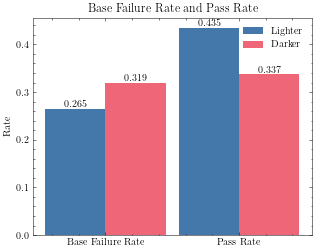

In [187]:
fig = get_real_fake_acc(pools[0]['result_path'], worker_skin_labels_grouped, metrics='acc')['fig']
fig.savefig('fairness/atten=gender_acc.pdf')

/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calli

(0.01, gender) is statistical significant, p-value=0.027917881985802764
(0.01, None) is statistical significant, p-value=0.010707810095895574


,Lighter_base_fail,Lighter_pass,Darker_base_fail,Darker_pass,Lighter_quality,Darker_quality
gender,0.242,0.299,0.239,0.281,0.419,0.394
None,0.253,0.282,0.201,0.247,0.396,0.347
eye color,0.237,0.278,0.232,0.271,0.413,0.402


,Lighter_base_fail,Lighter_pass,Darker_base_fail,Darker_pass,Lighter_quality,Darker_quality
eye color,0.234,0.403,0.231,0.367,0.525,0.479
None,0.291,0.340,0.294,0.328,0.480,0.464
gender,0.280,0.338,0.275,0.290,0.469,0.401


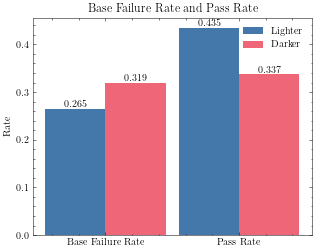

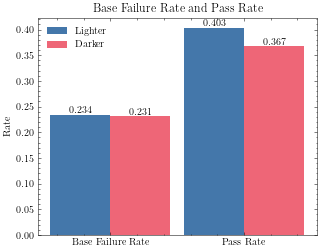

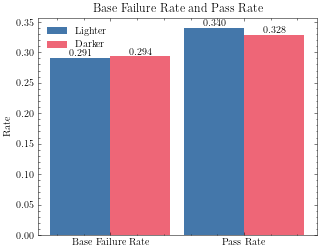

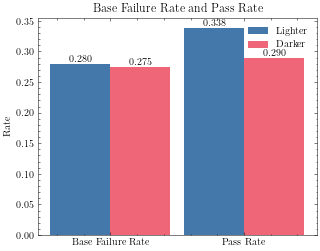

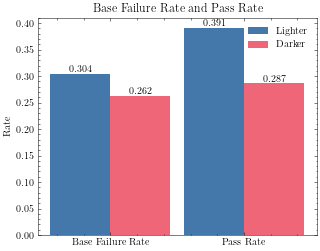

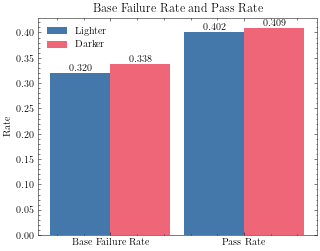

In [200]:
res_001 = {}
res_003 = {}

# use worker labels
balanced_set = worker_skin_labels_grouped

for pool in pools:
    if pool['payment_amount'] == 0.01:
        _res = get_real_fake_acc(pool['result_path'], balanced_set, metrics='acc')
        res_001[pool['attention_q']] = { 
            'Lighter_base_fail': (1-_res['real_lighter_acc']).std(),
            'Lighter_pass': (1-_res['fake_lighter_acc']).std(),
            'Darker_base_fail': (1-_res['real_darker_acc']).std(),
            'Darker_pass': (1-_res['fake_darker_acc']).std(),
            'Lighter_quality': ((1-_res['fake_lighter_acc']) / _res['real_imgs_acc']['acc'].mean()).std(),
            'Darker_quality': ((1-_res['fake_darker_acc']) / _res['real_imgs_acc']['acc'].mean()).std()
        }
        p_value = ttest_ind(
            (1-_res['fake_lighter_acc']) / _res['real_imgs_acc']['acc'].mean(), 
            (1-_res['fake_darker_acc']) / _res['real_imgs_acc']['acc'].mean())[1]
        if p_value < 0.05:
            print(f"({pool['payment_amount']}, {pool['attention_q']}) is statistical significant, p-value={p_value}")
    elif pool['payment_amount'] == 0.03:
        _res = get_real_fake_acc(pool['result_path'], balanced_set, metrics='acc')
        res_003[pool['attention_q']] = { 
            'Lighter_base_fail': (1-_res['real_lighter_acc']).mean(),
            'Lighter_pass': (1-_res['fake_lighter_acc']).mean(),
            'Darker_base_fail': (1-_res['real_darker_acc']).mean(),
            'Darker_pass': (1-_res['fake_darker_acc']).mean(),
            'Lighter_quality': ((1-_res['fake_lighter_acc']) / _res['real_imgs_acc']['acc'].mean()).mean(),
            'Darker_quality': ((1-_res['fake_darker_acc']) / _res['real_imgs_acc']['acc'].mean()).mean()
        }
        if ttest_ind(_res['fake_lighter_acc'], _res['fake_darker_acc'])[1] < 0.05:
            print(f"({pool['payment_amount']}, {pool['attention_q']})  is statistical significant, p-value={p_value}")

# pd.concat((pd.DataFrame.from_dict(res_001, orient='index'),
#     pd.DataFrame.from_dict(res_001, orient='index')), axis=1)

display(pd.DataFrame.from_dict(res_001, orient='index').applymap("{0:.3f}".format)) 
display(pd.DataFrame.from_dict(res_003, orient='index').applymap("{0:.3f}".format)) 

In [61]:
worker_acc_1 = pd.read_csv('fairness/fake_real_worker_acc/assignments_from_pool_33923754__20-06-2022.tsv',
    sep='\t').dropna(axis=0, how='all')
worker_acc_1['n_tasks'] = np.ones(len(worker_acc_1))
worker_acc_2 = pd.read_csv('fairness/fake_real_worker_acc/assignments_from_pool_33957988__20-06-2022.tsv',
    sep='\t').dropna(axis=0, how='all')
worker_acc_2['n_tasks'] = np.ones(len(worker_acc_2))
worker_acc_3 = pd.read_csv('fairness/fake_real_worker_acc/assignments_from_pool_33987192__20-06-2022.tsv',
    sep='\t').dropna(axis=0, how='all')
worker_acc_3['n_tasks'] = np.ones(len(worker_acc_3))
worker_acc_4 = pd.read_csv('fairness/fake_real_worker_acc/assignments_from_pool_34019892__22-06-2022.tsv',
    sep='\t').dropna(axis=0, how='all')
worker_acc_4['n_tasks'] = np.ones(len(worker_acc_4))

worker_acc = worker_acc_4
worker_acc['INPUT:image'] = worker_acc['INPUT:image'].apply(lambda x: x.replace('"', ''))
worker_acc['n_tasks'] = np.ones(len(worker_acc))

In [62]:
worker_final_acc = worker_acc[['INPUT:image', 'OUTPUT:result', 'GOLDEN:result', 'n_tasks']].groupby('INPUT:image').sum().reset_index()

In [63]:
worker_final_acc = worker_final_acc.merge(balanced_set, on='INPUT:image')

In [64]:
worker_final_acc_real = worker_final_acc[worker_final_acc['GOLDEN:result'] == 0.]
worker_final_acc_fake = worker_final_acc[worker_final_acc['GOLDEN:result'] > 0]

In [65]:
worker_final_acc_fake['acc'] = worker_final_acc_fake['OUTPUT:result'] / worker_final_acc_fake['GOLDEN:result']
worker_final_acc_real['acc'] = (worker_final_acc_real['n_tasks'] - worker_final_acc_real['OUTPUT:result']) / (worker_final_acc_real['n_tasks'] - worker_final_acc_real['GOLDEN:result'])

/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/birk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
worker_final_acc_fake['acc'].mean()

0.6779999999999999

In [67]:
worker_final_acc_real['acc'].mean()

0.7219999999999999

In [69]:
from scipy.stats import ttest_ind

ttest_ind(worker_final_acc_fake[worker_final_acc_fake['skin']==0]['acc'], worker_final_acc_fake[worker_final_acc_fake['skin']==1]['acc'])
# worker_final_acc_fake['acc']

Ttest_indResult(statistic=0.31403262795805975, pvalue=0.7538268737395128)

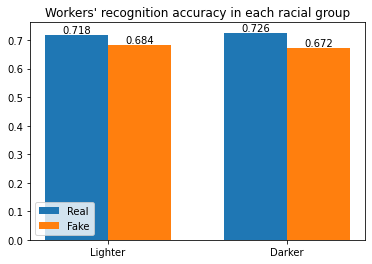

In [28]:
fig = freq_bar(
    real_y=worker_final_acc_real.groupby('skin').mean()['acc'],
    fake_y=worker_final_acc_fake.groupby('skin').mean()['acc'],
    # skin_acc[500:].groupby('skin').mean()['acc'],
    # skin_acc[:500].groupby('skin').mean()['acc'],
    title="Workers' recognition accuracy in each racial group"
)

#### Same Workers?

In [44]:
worker_1 = worker_acc_1.groupby('ASSIGNMENT:worker_id').count()[['n_tasks']].reset_index()
worker_2 = worker_acc_2.groupby('ASSIGNMENT:worker_id').count()[['n_tasks']].reset_index()
worker_3 = worker_acc_3.groupby('ASSIGNMENT:worker_id').count()[['n_tasks']].reset_index()
worker_4 = worker_acc_4.groupby('ASSIGNMENT:worker_id').count()[['n_tasks']].reset_index()

In [53]:
worker_4.merge(worker_3, on='ASSIGNMENT:worker_id', how='inner', suffixes=('_4', '_3'))

,ASSIGNMENT:worker_id,n_tasks_4,n_tasks_3
0,acc78d5fb3575c0e4436abdd4ad25f54,5,6
1,b975dbd0d3a40e5adf3c4f3d2e955e25,5,8
2,bd329f3fa22fe0233ec2de4f4776e124,15,78


In [55]:
worker_4.merge(worker_2, on='ASSIGNMENT:worker_id', how='inner', suffixes=('_4', '_2'))

,ASSIGNMENT:worker_id,n_tasks_4,n_tasks_2
0,12899c42f5ef8eb776a7f5ed61ed8923,17,32
1,bdbe98229133bd5472d03e4e4e8c2d20,109,163
2,f4ac6258c680466cfd43b7f012b24288,17,23


In [56]:
worker_4.merge(worker_3, on='ASSIGNMENT:worker_id', how='inner', suffixes=('_4', '_1'))

,ASSIGNMENT:worker_id,n_tasks_4,n_tasks_1
0,acc78d5fb3575c0e4436abdd4ad25f54,5,6
1,b975dbd0d3a40e5adf3c4f3d2e955e25,5,8
2,bd329f3fa22fe0233ec2de4f4776e124,15,78
